# Steering Image Dataset - Exploratory Data Analysis

This notebook performs comprehensive EDA on the steering direction image dataset:
- **Left**: Images where the vehicle should turn left
- **Forward**: Images where the vehicle should go straight
- **Right**: Images where the vehicle should turn right


In [1]:
import numpy as np
import cv2
import os
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import entropy
import pandas as pd

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
DATA_DIR = Path('../data/raw')
CLASSES = ['left', 'forward', 'right']
CLASS_COLORS = {'left': '#e74c3c', 'forward': '#27ae60', 'right': '#3498db'}


---
## 1. Dataset Overview

Load all images and examine the class distribution.


In [2]:
def load_images_from_directory(directory):
    """Load all PNG images from a directory."""
    images = []
    image_paths = sorted(glob(str(directory / '*.png')))
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

# Load all images by class
images_by_class = {}
for cls in CLASSES:
    images_by_class[cls] = load_images_from_directory(DATA_DIR / cls)
    print(f"Loaded {len(images_by_class[cls])} images for class '{cls}'")

# Total count
total_images = sum(len(imgs) for imgs in images_by_class.values())
print(f"\nTotal images: {total_images}")


Loaded 1620 images for class 'left'
Loaded 7343 images for class 'forward'
Loaded 937 images for class 'right'

Total images: 9900


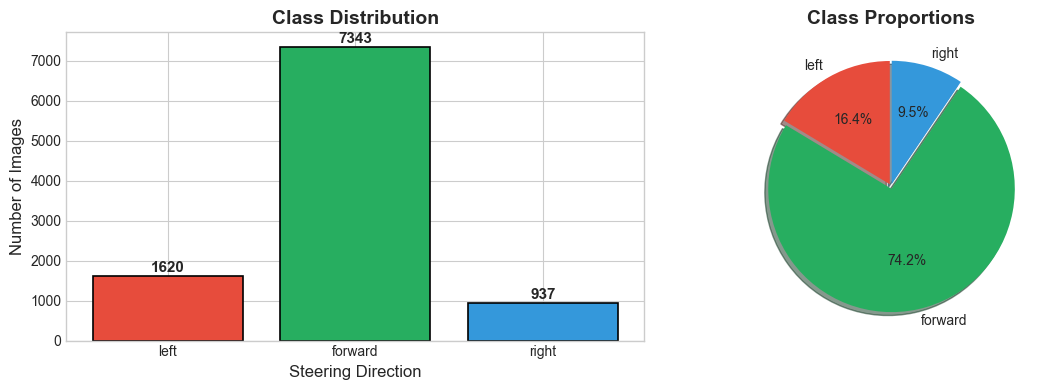

In [3]:
# Display class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
counts = [len(images_by_class[cls]) for cls in CLASSES]
colors = [CLASS_COLORS[cls] for cls in CLASSES]
bars = axes[0].bar(CLASSES, counts, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Steering Direction', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(counts, labels=CLASSES, autopct='%1.1f%%', colors=colors,
            explode=[0.02]*3, shadow=True, startangle=90)
axes[1].set_title('Class Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [4]:
# Report image dimensions and data types
sample_img = images_by_class['forward'][0]
print("Image Properties:")
print(f"  Shape: {sample_img.shape}")
print(f"  Data type: {sample_img.dtype}")
print(f"  Pixel value range: [{sample_img.min()}, {sample_img.max()}]")
print(f"  Total pixels per image: {sample_img.size}")


Image Properties:
  Shape: (64, 64)
  Data type: uint8
  Pixel value range: [20, 138]
  Total pixels per image: 4096


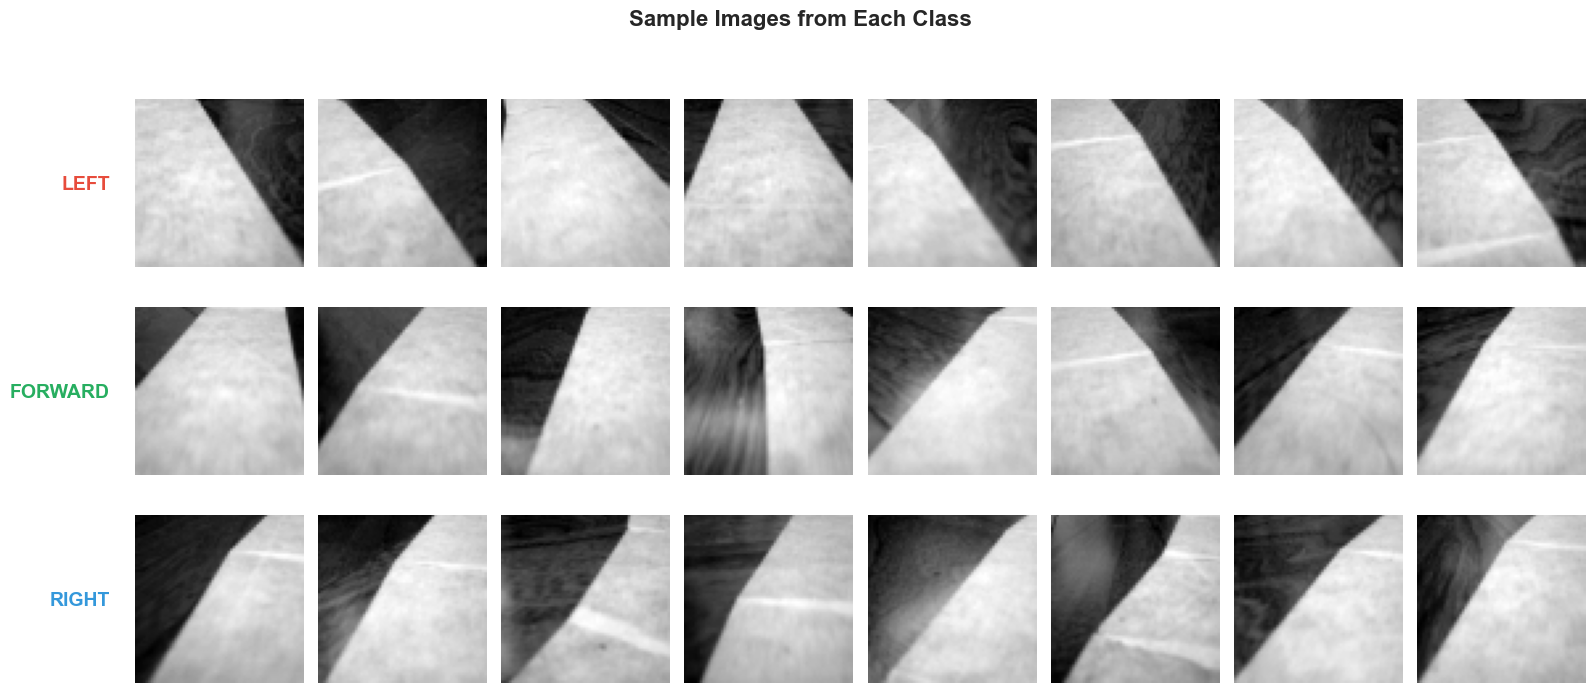

In [5]:
# Show sample images from each class in a grid
fig, axes = plt.subplots(3, 8, figsize=(16, 7))

for row, cls in enumerate(CLASSES):
    # Get random sample indices
    np.random.seed(42)
    sample_indices = np.random.choice(len(images_by_class[cls]), 8, replace=False)
    
    for col, idx in enumerate(sample_indices):
        axes[row, col].imshow(images_by_class[cls][idx], cmap='gray')
        axes[row, col].axis('off')

# Add row labels on the left
for row, cls in enumerate(CLASSES):
    axes[row, 0].text(-10, 32, cls.upper(), fontsize=14, fontweight='bold',
                      ha='right', va='center', color=CLASS_COLORS[cls])

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


---
## 2. Image Overlays

Compute the mean and variance images for each class to reveal typical patterns.


In [6]:
# Compute mean images for each class
mean_images = {}
for cls in CLASSES:
    mean_images[cls] = np.mean(images_by_class[cls].astype(np.float64), axis=0)
    print(f"Mean image for '{cls}': min={mean_images[cls].min():.2f}, max={mean_images[cls].max():.2f}")


Mean image for 'left': min=35.09, max=135.68
Mean image for 'forward': min=44.97, max=130.12
Mean image for 'right': min=36.95, max=136.42


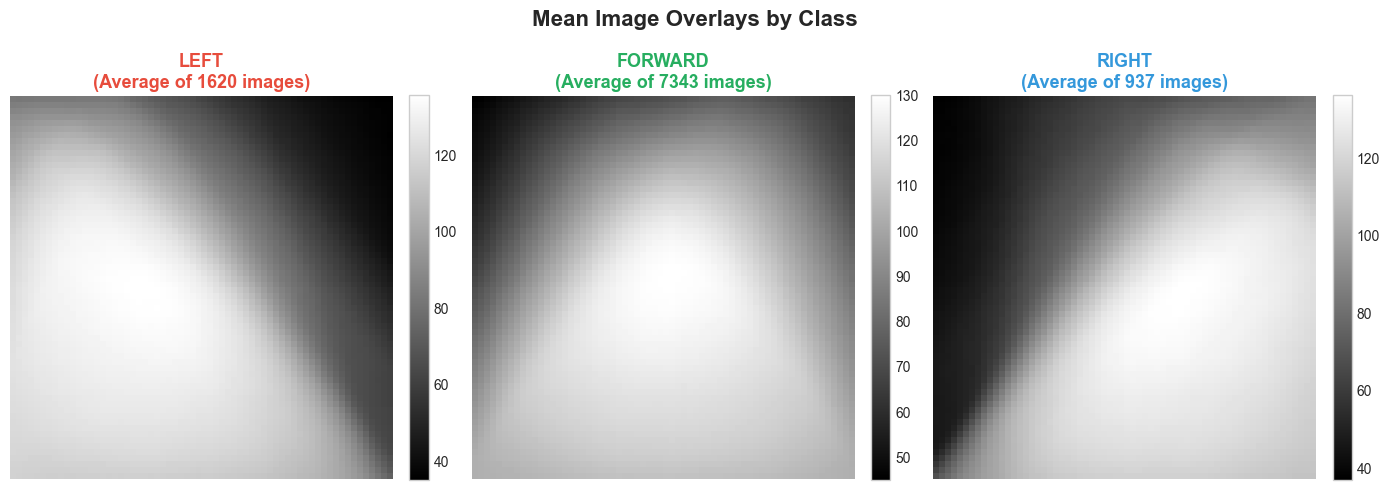

In [7]:
# Display mean images side-by-side
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for ax, cls in zip(axes, CLASSES):
    im = ax.imshow(mean_images[cls], cmap='gray')
    ax.set_title(f'{cls.upper()}\n(Average of {len(images_by_class[cls])} images)',
                 fontsize=13, fontweight='bold', color=CLASS_COLORS[cls])
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Mean Image Overlays by Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [10]:
# Compute variance images for each class
variance_images = {}
for cls in CLASSES:
    variance_images[cls] = np.var(images_by_class[cls].astype(np.float64), axis=0)
    print(f"Variance image for '{cls}': min={variance_images[cls].min():.2f}, max={variance_images[cls].max():.2f}")


Variance image for 'left': min=167.03, max=1928.19
Variance image for 'forward': min=48.15, max=1831.28
Variance image for 'right': min=211.40, max=1592.57


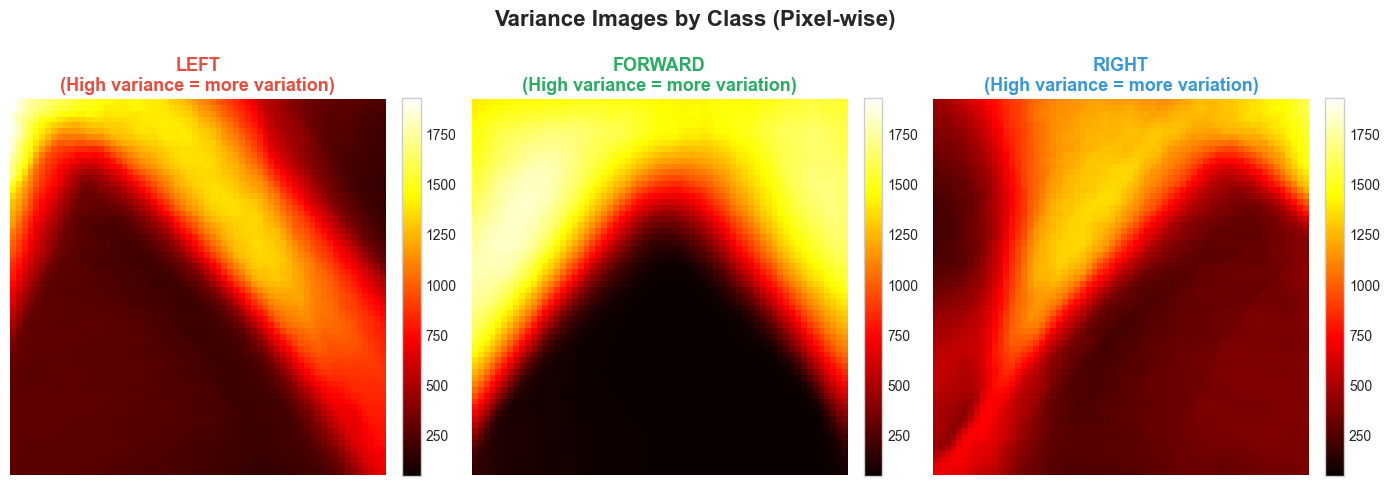

In [11]:
# Display variance images side-by-side
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Find global min/max for consistent colorbar
vmin = min(v.min() for v in variance_images.values())
vmax = max(v.max() for v in variance_images.values())

for ax, cls in zip(axes, CLASSES):
    im = ax.imshow(variance_images[cls], cmap='hot', vmin=vmin, vmax=vmax)
    ax.set_title(f'{cls.upper()}\n(High variance = more variation)',
                 fontsize=13, fontweight='bold', color=CLASS_COLORS[cls])
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Variance Images by Class (Pixel-wise)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


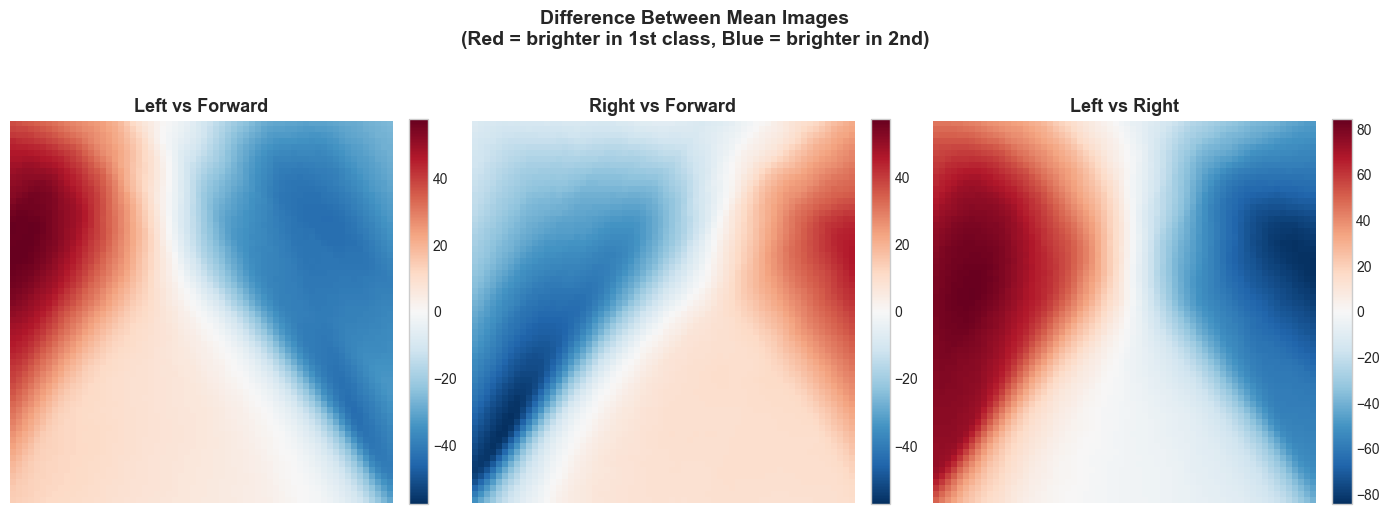

In [12]:
# Difference between mean images
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

comparisons = [
    ('left', 'forward', 'Left vs Forward'),
    ('right', 'forward', 'Right vs Forward'),
    ('left', 'right', 'Left vs Right')
]

for ax, (cls1, cls2, title) in zip(axes, comparisons):
    diff = mean_images[cls1] - mean_images[cls2]
    vabs = max(abs(diff.min()), abs(diff.max()))
    im = ax.imshow(diff, cmap='RdBu_r', vmin=-vabs, vmax=vabs)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Difference Between Mean Images\n(Red = brighter in 1st class, Blue = brighter in 2nd)',
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


---
## 3. Vectorized Image Comparison

Flatten images to vectors and use dimensionality reduction to visualize class separation.


In [13]:
# Flatten all images into vectors
X_list = []
y_list = []

for cls in CLASSES:
    n_samples = len(images_by_class[cls])
    # Flatten each image to a 4096-dimensional vector
    flattened = images_by_class[cls].reshape(n_samples, -1)
    X_list.append(flattened)
    y_list.extend([cls] * n_samples)

X = np.vstack(X_list).astype(np.float64)
y = np.array(y_list)

# Normalize to [0, 1]
X_normalized = X / 255.0

print(f"Feature matrix shape: {X_normalized.shape}")
print(f"Labels shape: {y.shape}")


Feature matrix shape: (9900, 4096)
Labels shape: (9900,)


In [14]:
# Apply PCA
print("Fitting PCA...")
pca = PCA(n_components=50)  # Keep 50 components for analysis
X_pca_50 = pca.fit_transform(X_normalized)

# Explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by first 2 components: {cumulative_variance[1]:.2%}")
print(f"Variance explained by first 10 components: {cumulative_variance[9]:.2%}")
print(f"Variance explained by first 50 components: {cumulative_variance[49]:.2%}")


Fitting PCA...
Variance explained by first 2 components: 66.86%
Variance explained by first 10 components: 86.76%
Variance explained by first 50 components: 95.73%


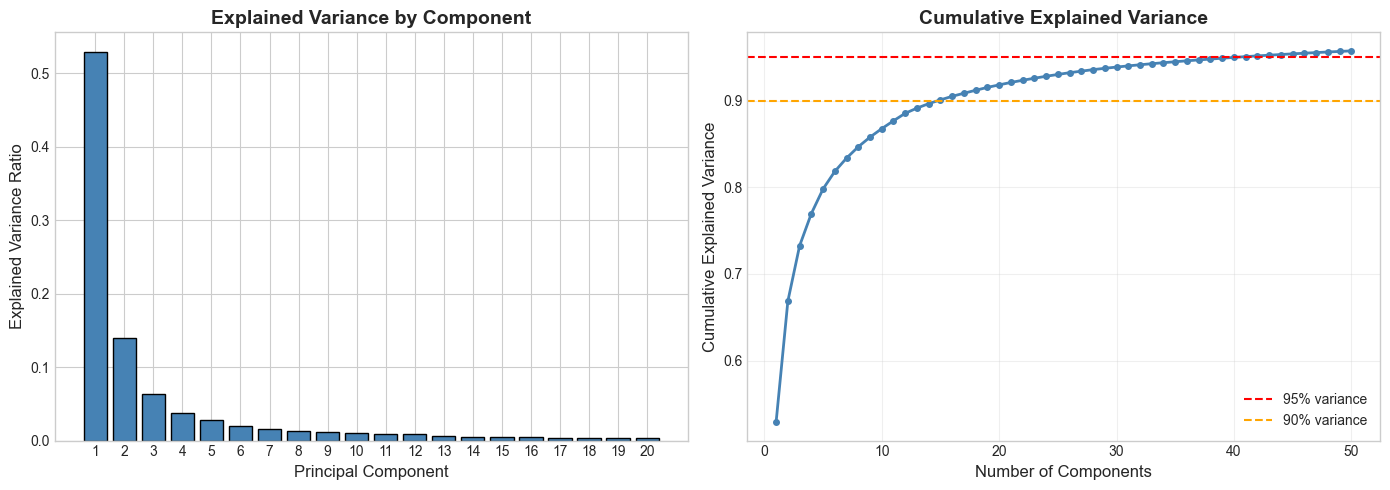

In [15]:
# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].bar(range(1, 21), pca.explained_variance_ratio_[:20], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Explained Variance by Component', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 21))

# Cumulative variance
axes[1].plot(range(1, 51), cumulative_variance, 'o-', color='steelblue', linewidth=2, markersize=4)
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


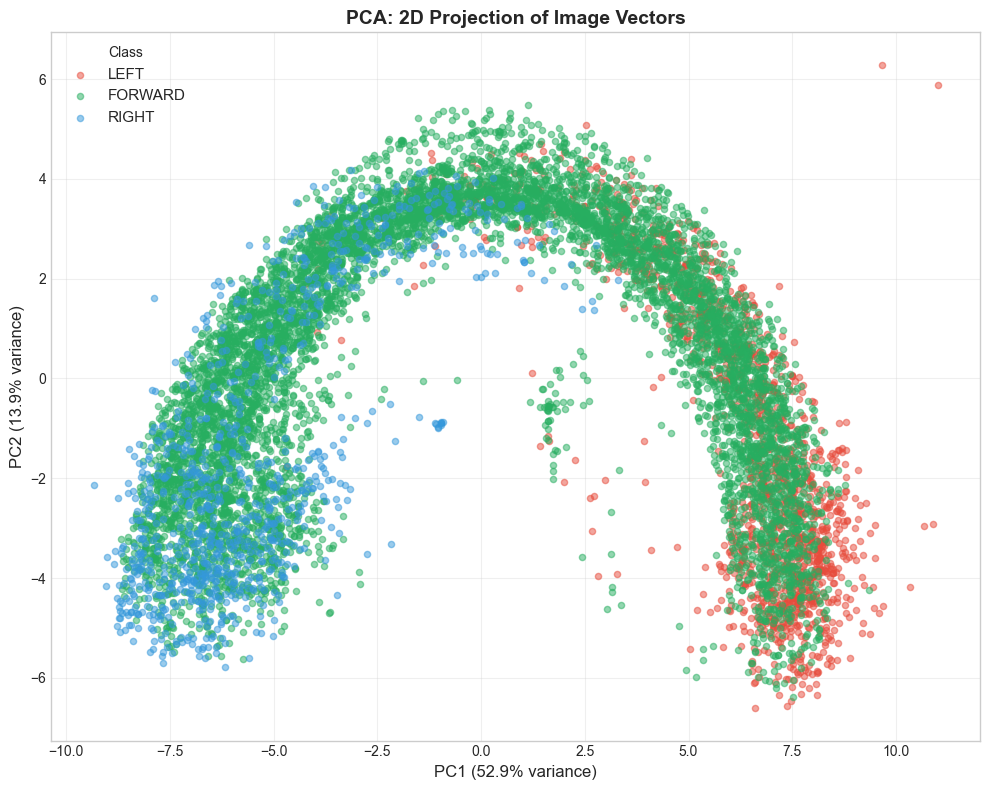

In [16]:
# PCA scatter plot (2D)
X_pca_2d = X_pca_50[:, :2]

fig, ax = plt.subplots(figsize=(10, 8))

for cls in CLASSES:
    mask = y == cls
    ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
               c=CLASS_COLORS[cls], label=cls.upper(), alpha=0.5, s=20)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('PCA: 2D Projection of Image Vectors', fontsize=14, fontweight='bold')
ax.legend(title='Class', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


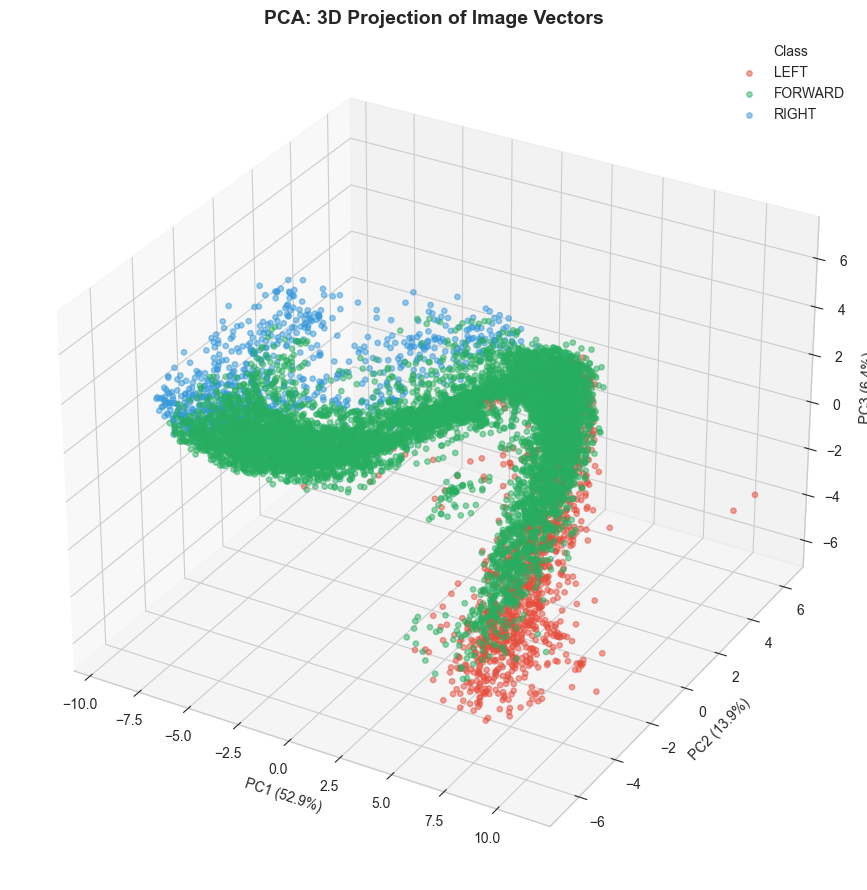

In [17]:
# PCA scatter plot (3D)
from mpl_toolkits.mplot3d import Axes3D

X_pca_3d = X_pca_50[:, :3]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for cls in CLASSES:
    mask = y == cls
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
               c=CLASS_COLORS[cls], label=cls.upper(), alpha=0.5, s=15)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=10)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=10)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize=10)
ax.set_title('PCA: 3D Projection of Image Vectors', fontsize=14, fontweight='bold')
ax.legend(title='Class', fontsize=10)

plt.tight_layout()
plt.show()


In [19]:
# t-SNE embedding (subsample for speed)
print("Fitting t-SNE (this may take a minute)...")

# Subsample if dataset is large
n_samples_tsne = min(3000, len(X_normalized))
np.random.seed(42)
indices = np.random.choice(len(X_normalized), n_samples_tsne, replace=False)

X_subset = X_normalized[indices]
y_subset = y[indices]

# Use PCA-reduced data for faster t-SNE
X_pca_for_tsne = X_pca_50[indices]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca_for_tsne)
print("t-SNE complete!")


Fitting t-SNE (this may take a minute)...
t-SNE complete!


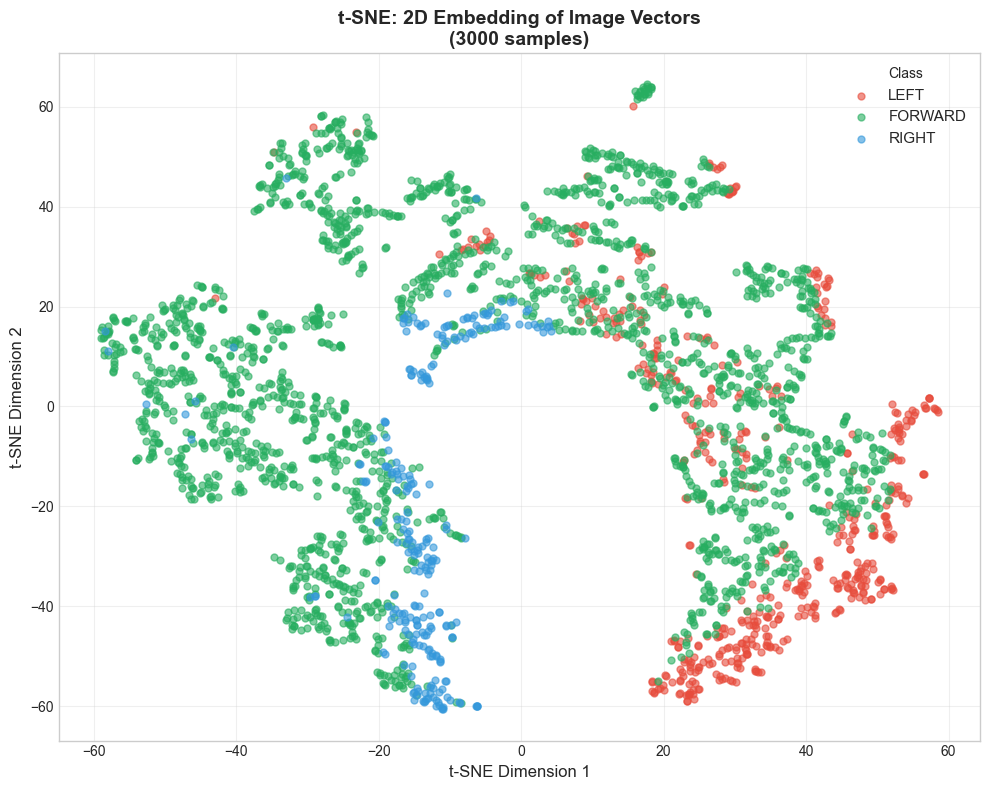

In [20]:
# t-SNE scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

for cls in CLASSES:
    mask = y_subset == cls
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=CLASS_COLORS[cls], label=cls.upper(), alpha=0.6, s=25)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title(f't-SNE: 2D Embedding of Image Vectors\n({n_samples_tsne} samples)', fontsize=14, fontweight='bold')
ax.legend(title='Class', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Pairwise Euclidean Distances Between Class Centroids:
--------------------------------------------------
  LEFT <-> FORWARD: 7.1800
  LEFT <-> RIGHT: 12.1022
  FORWARD <-> RIGHT: 5.9756


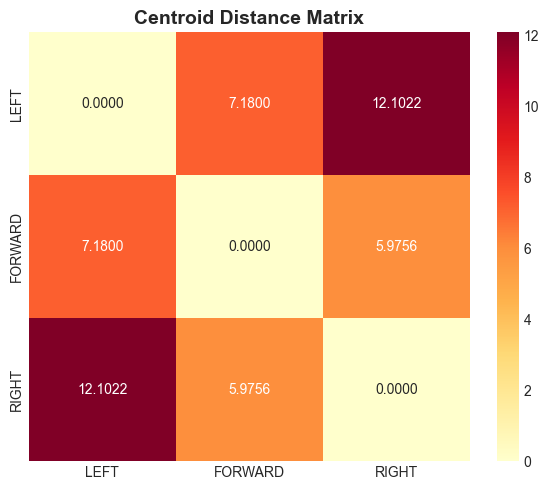

In [21]:
# Compute class centroids and pairwise distances
centroids = {}
for cls in CLASSES:
    mask = y == cls
    centroids[cls] = np.mean(X_normalized[mask], axis=0)

# Pairwise Euclidean distances between centroids
print("Pairwise Euclidean Distances Between Class Centroids:")
print("-" * 50)
distance_matrix = np.zeros((3, 3))
for i, cls1 in enumerate(CLASSES):
    for j, cls2 in enumerate(CLASSES):
        dist = np.linalg.norm(centroids[cls1] - centroids[cls2])
        distance_matrix[i, j] = dist
        if i < j:
            print(f"  {cls1.upper()} <-> {cls2.upper()}: {dist:.4f}")

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(distance_matrix, annot=True, fmt='.4f', cmap='YlOrRd',
            xticklabels=[c.upper() for c in CLASSES],
            yticklabels=[c.upper() for c in CLASSES], ax=ax)
ax.set_title('Centroid Distance Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---
## 4. Additional EDA

Pixel intensity distributions, edge detection, and summary statistics.


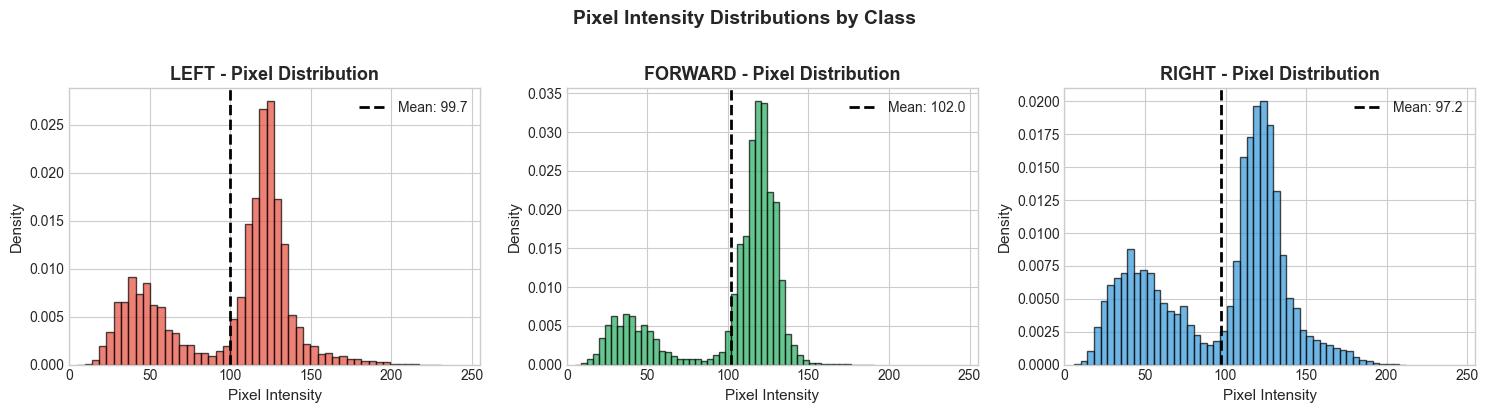

In [22]:
# Pixel intensity histograms per class
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, cls in zip(axes, CLASSES):
    # Flatten all pixels for this class
    all_pixels = images_by_class[cls].flatten()
    ax.hist(all_pixels, bins=50, color=CLASS_COLORS[cls], alpha=0.7, edgecolor='black', density=True)
    ax.set_xlabel('Pixel Intensity', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{cls.upper()} - Pixel Distribution', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 255)
    ax.axvline(all_pixels.mean(), color='black', linestyle='--', linewidth=2, label=f'Mean: {all_pixels.mean():.1f}')
    ax.legend()

plt.suptitle('Pixel Intensity Distributions by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


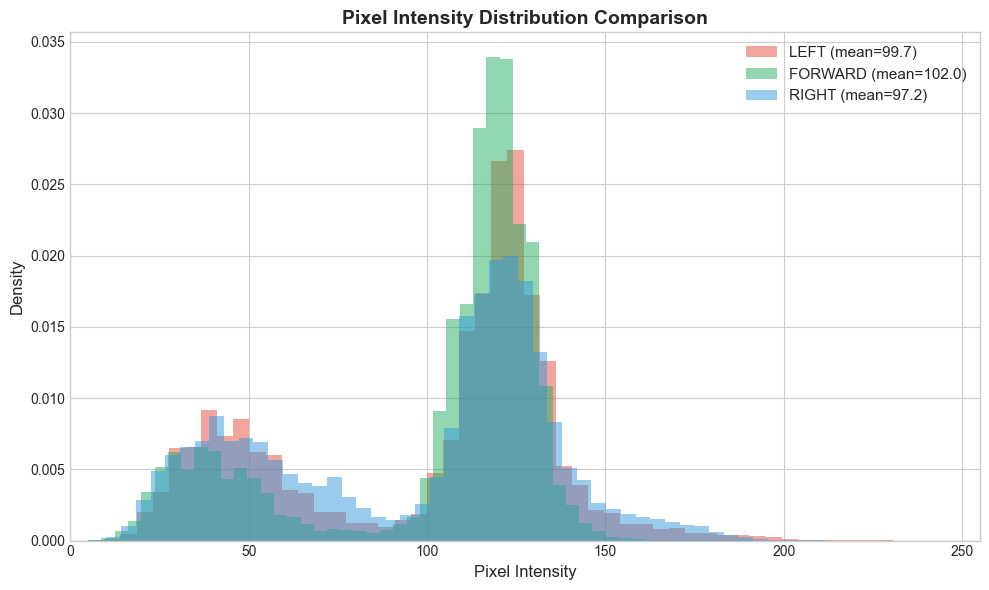

In [23]:
# Overlaid histogram comparison
fig, ax = plt.subplots(figsize=(10, 6))

for cls in CLASSES:
    all_pixels = images_by_class[cls].flatten()
    ax.hist(all_pixels, bins=50, color=CLASS_COLORS[cls], alpha=0.5,
            label=f'{cls.upper()} (mean={all_pixels.mean():.1f})', density=True)

ax.set_xlabel('Pixel Intensity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Pixel Intensity Distribution Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xlim(0, 255)

plt.tight_layout()
plt.show()


In [24]:
# Edge detection analysis using Sobel
def compute_edge_magnitude(img):
    """Compute edge magnitude using Sobel operator."""
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    return magnitude

# Compute mean edge image for each class
mean_edge_images = {}
for cls in CLASSES:
    edge_images = np.array([compute_edge_magnitude(img) for img in images_by_class[cls]])
    mean_edge_images[cls] = np.mean(edge_images, axis=0)
    print(f"Mean edge magnitude for '{cls}': {mean_edge_images[cls].mean():.2f}")


Mean edge magnitude for 'left': 26.97
Mean edge magnitude for 'forward': 24.80
Mean edge magnitude for 'right': 28.22


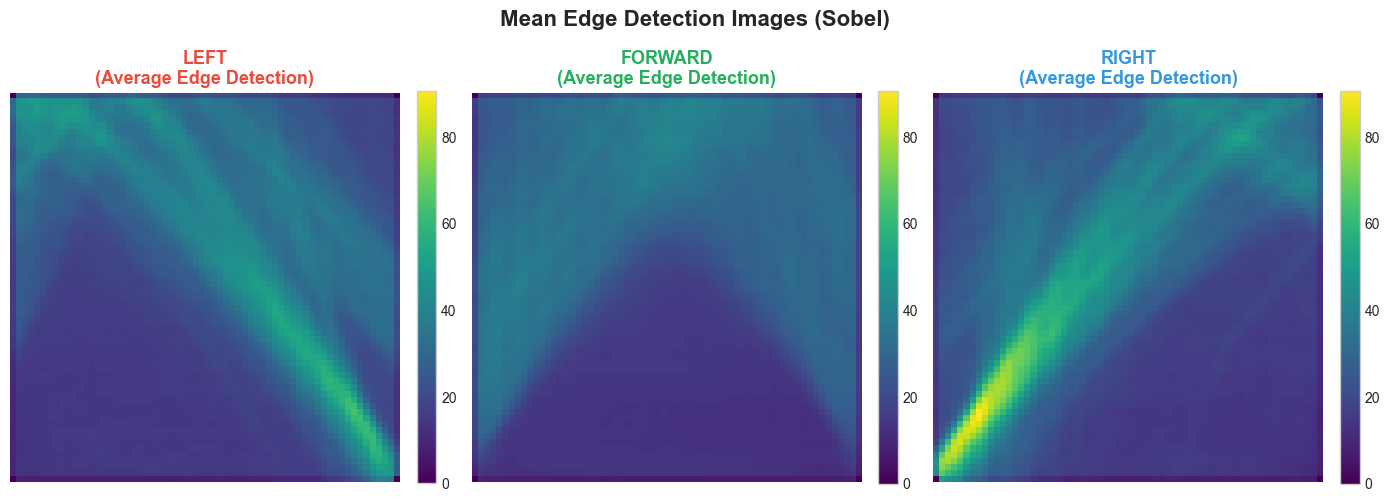

In [25]:
# Display mean edge images
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

vmax = max(img.max() for img in mean_edge_images.values())

for ax, cls in zip(axes, CLASSES):
    im = ax.imshow(mean_edge_images[cls], cmap='viridis', vmax=vmax)
    ax.set_title(f'{cls.upper()}\n(Average Edge Detection)',
                 fontsize=13, fontweight='bold', color=CLASS_COLORS[cls])
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Mean Edge Detection Images (Sobel)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


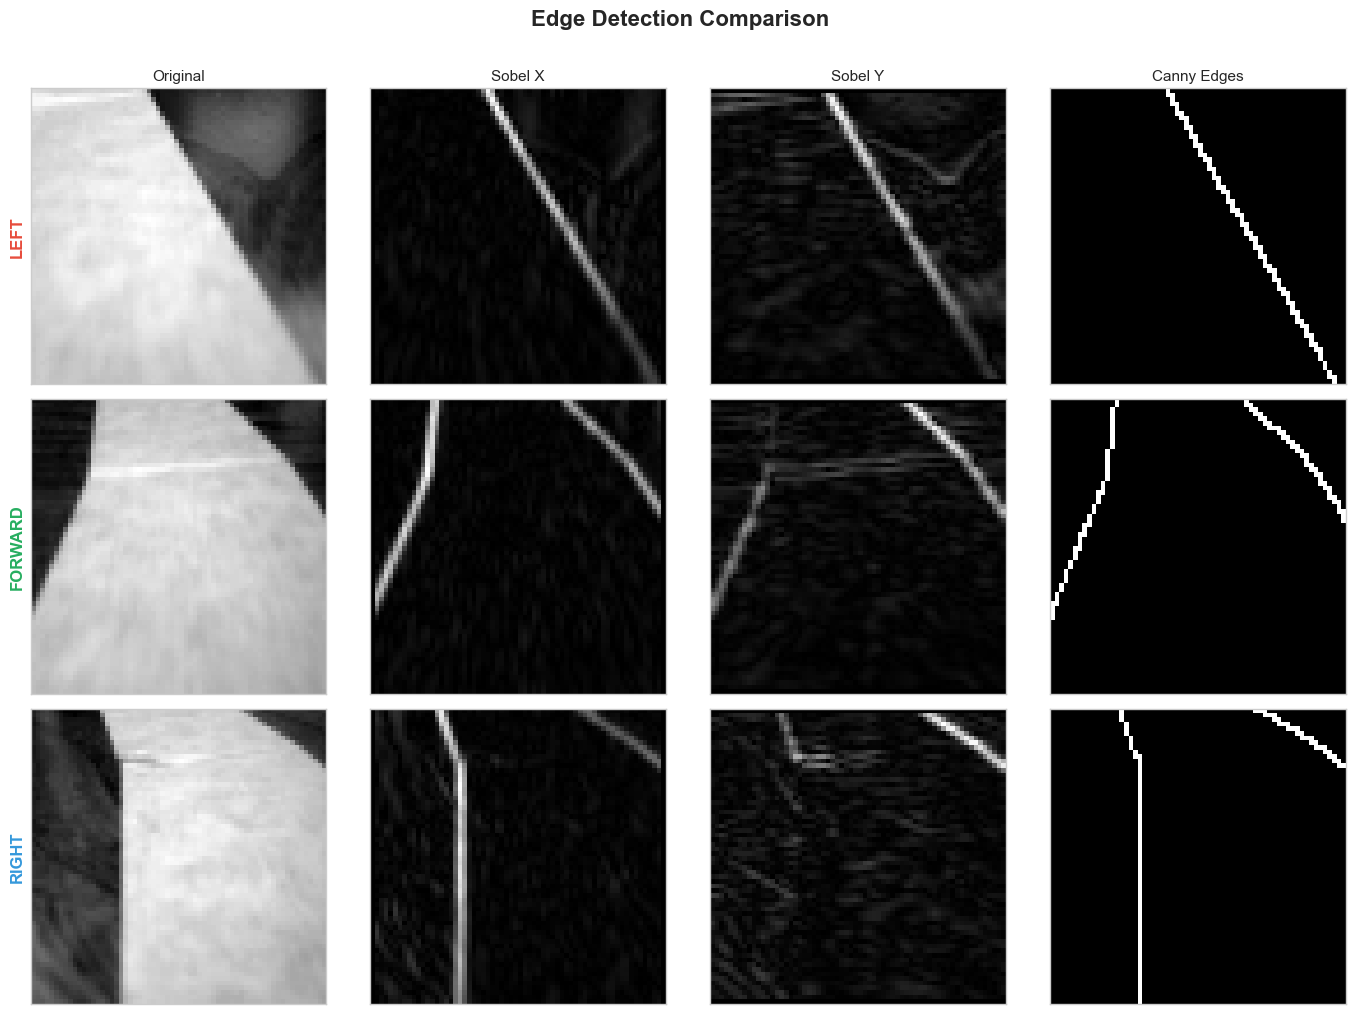

In [32]:
# Sample edge detection comparison
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

np.random.seed(129)
for row, cls in enumerate(CLASSES):
    idx = np.random.randint(len(images_by_class[cls]))
    img = images_by_class[cls][idx]
    
    # Original
    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].set_title('Original' if row == 0 else '', fontsize=11)
    axes[row, 0].set_ylabel(cls.upper(), fontsize=12, fontweight='bold', color=CLASS_COLORS[cls])
    
    # Sobel X
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    axes[row, 1].imshow(np.abs(sobelx), cmap='gray')
    axes[row, 1].set_title('Sobel X' if row == 0 else '', fontsize=11)
    
    # Sobel Y
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    axes[row, 2].imshow(np.abs(sobely), cmap='gray')
    axes[row, 2].set_title('Sobel Y' if row == 0 else '', fontsize=11)
    
    # Canny
    canny = cv2.Canny(img, 50, 150)
    axes[row, 3].imshow(canny, cmap='gray')
    axes[row, 3].set_title('Canny Edges' if row == 0 else '', fontsize=11)

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Edge Detection Comparison', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()


In [33]:
# Per-class statistics table
def compute_image_entropy(img):
    """Compute entropy of an image based on histogram."""
    hist, _ = np.histogram(img, bins=256, range=(0, 256), density=True)
    hist = hist[hist > 0]  # Remove zeros
    return entropy(hist)

stats_data = []
for cls in CLASSES:
    imgs = images_by_class[cls]
    
    # Compute statistics
    mean_brightness = np.mean(imgs)
    std_brightness = np.std(imgs)
    mean_entropy = np.mean([compute_image_entropy(img) for img in imgs])
    mean_edge = np.mean([compute_edge_magnitude(img).mean() for img in imgs])
    
    stats_data.append({
        'Class': cls.upper(),
        'Count': len(imgs),
        'Mean Brightness': f'{mean_brightness:.2f}',
        'Std Brightness': f'{std_brightness:.2f}',
        'Mean Entropy': f'{mean_entropy:.3f}',
        'Mean Edge Mag': f'{mean_edge:.2f}'
    })

stats_df = pd.DataFrame(stats_data)
print("\nPer-Class Statistics:")
print("=" * 80)
stats_df



Per-Class Statistics:


,Class,Count,Mean Brightness,Std Brightness,Mean Entropy,Mean Edge Mag
0,LEFT,1620,99.75,39.00,4.158,26.97
1,FORWARD,7343,101.95,34.36,4.037,24.80
2,RIGHT,937,97.20,40.33,4.265,28.22


/var/folders/vq/7q4x3l_x3y995gq_7md78y1w0000gn/T/ipykernel_56373/1696279840.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(brightness_data, labels=[c.upper() for c in CLASSES], patch_artist=True)
/var/folders/vq/7q4x3l_x3y995gq_7md78y1w0000gn/T/ipykernel_56373/1696279840.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(std_data, labels=[c.upper() for c in CLASSES], patch_artist=True)
/var/folders/vq/7q4x3l_x3y995gq_7md78y1w0000gn/T/ipykernel_56373/1696279840.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = axes[2].boxplot(entropy_data, labels=[c.upper() f

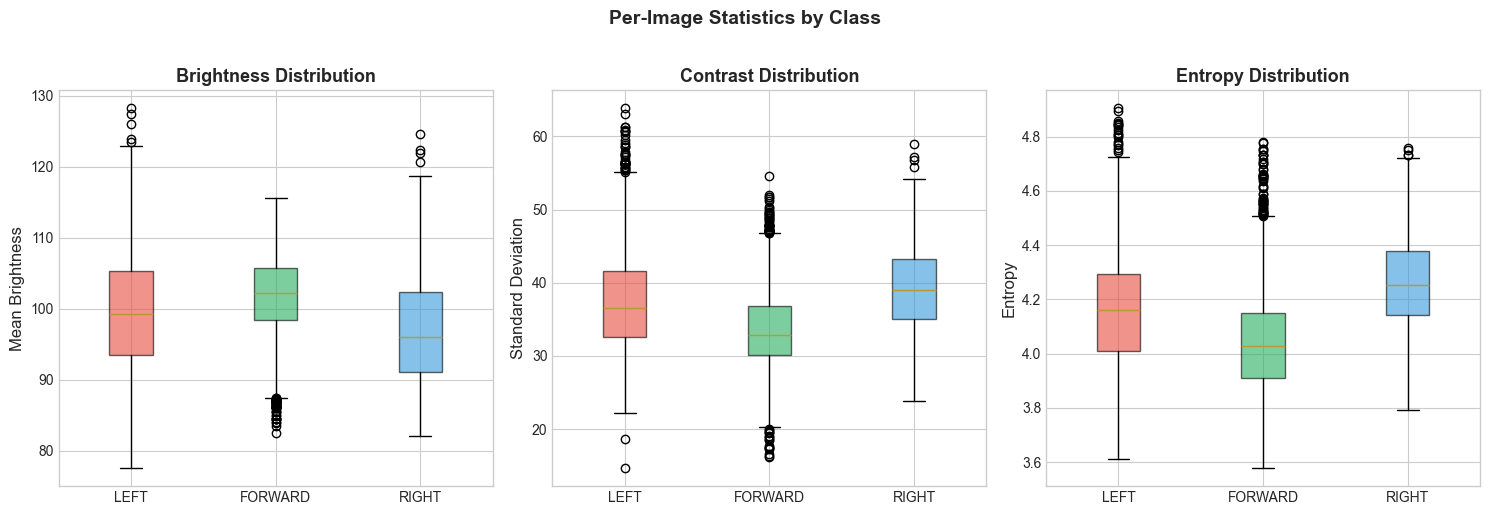

In [34]:
# Box plots for per-image statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mean brightness per image
brightness_data = []
for cls in CLASSES:
    means = [img.mean() for img in images_by_class[cls]]
    brightness_data.append(means)

bp1 = axes[0].boxplot(brightness_data, labels=[c.upper() for c in CLASSES], patch_artist=True)
for patch, cls in zip(bp1['boxes'], CLASSES):
    patch.set_facecolor(CLASS_COLORS[cls])
    patch.set_alpha(0.6)
axes[0].set_ylabel('Mean Brightness', fontsize=12)
axes[0].set_title('Brightness Distribution', fontsize=13, fontweight='bold')

# Standard deviation per image
std_data = []
for cls in CLASSES:
    stds = [img.std() for img in images_by_class[cls]]
    std_data.append(stds)

bp2 = axes[1].boxplot(std_data, labels=[c.upper() for c in CLASSES], patch_artist=True)
for patch, cls in zip(bp2['boxes'], CLASSES):
    patch.set_facecolor(CLASS_COLORS[cls])
    patch.set_alpha(0.6)
axes[1].set_ylabel('Standard Deviation', fontsize=12)
axes[1].set_title('Contrast Distribution', fontsize=13, fontweight='bold')

# Entropy per image
entropy_data = []
for cls in CLASSES:
    entropies = [compute_image_entropy(img) for img in images_by_class[cls]]
    entropy_data.append(entropies)

bp3 = axes[2].boxplot(entropy_data, labels=[c.upper() for c in CLASSES], patch_artist=True)
for patch, cls in zip(bp3['boxes'], CLASSES):
    patch.set_facecolor(CLASS_COLORS[cls])
    patch.set_alpha(0.6)
axes[2].set_ylabel('Entropy', fontsize=12)
axes[2].set_title('Entropy Distribution', fontsize=13, fontweight='bold')

plt.suptitle('Per-Image Statistics by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


---
## Summary

This EDA notebook analyzed the steering direction image dataset:

1. **Dataset Overview**: Examined class distribution and sample images
2. **Image Overlays**: Created mean and variance images to reveal typical patterns per class
3. **Vectorized Comparison**: Used PCA and t-SNE to visualize class separability in feature space
4. **Additional Analysis**: Explored pixel distributions, edge patterns, and per-class statistics

Key findings should inform model selection and feature engineering for the classification task.
